In [2]:
import numpy as np
import pandas as pd
import googlemaps
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from importlib import reload


import BART as bart
import geocoding as geo
reload(bart)
reload(geo)

<module 'geocoding' from '/home/elliott/Dropbox/projects/BART/analysis/geocoding.py'>

In [3]:
#~ Various clients
with open("../../../.mapbox_token") as token: px.set_mapbox_access_token(token.read())
gmaps = geo.gmapsClient()

#~ Read & Prep Datasets
B = bart.ride_data("../data/date-hour-soo-dest-2020.csv")
stations = bart.station_data("../data/stations.csv")

In [4]:
codes = stations.index.to_list()
codes.remove("MLPT")

fig = bart.stationMap(stations)

In [5]:
fig.write_json("BartMap.json")

In [2]:
#~ Imports & globals
import numpy as np
import pandas as pd
import geocoding as geo

import googlemaps
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

def toInt(x):
    try: return int(x)
    except: return x

def graph_javascript(graphdiv,graphjson,positiondiv):
    
    script_template = """<style>
        var graphDiv = document.getElementById('{positiondiv}');
        var newGraph  = document.createElement('{graphdiv}');
        graphDiv.parentNode.insertBefore(newGraph, graphDiv);

            Plotly.d3.json("{graphjson}", function(plotly_data) {
            var config = {responsive: true}
            Plotly.newPlot('{graphid}', plotly_data.data, plotly_data.layout, config ); })
        </style>
        """
    txt = script_template.format(graphdiv=graphdiv,graphjson=graphjson,positiondiv=positiondiv)
    return txt

def expressMap():
    """
    from https://plotly.com/python/scattermapbox/
    """
    df = px.data.carshare()
    fig = px.scatter_mapbox(df, lat="centroid_lat", lon="centroid_lon",     color="peak_hour", size="car_hours",
                    color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
    return fig

with open("../../../.mapbox_token") as token: px.set_mapbox_access_token(token.read())

In [3]:
def ride_data(File,columns=['date','hour','enter','exit','rides'],**kwargs):
    """
    
    """
    B = pd.read_csv(File,header=None,names=columns,**kwargs)
    B['date'] += B['hour'].apply(lambda h: " {:02d}:00:00".format(h))
    B['date'] = pd.to_datetime(B['date'])
    B = B.drop('hour',axis=1).set_index(['date','enter','exit'])
    B = B.unstack('exit').fillna(0)['rides']
    
    return B


B = ride_data("../data/date-hour-soo-dest-2020.csv")

In [8]:
B['day'] = [x.date() for x in B.index.get_level_values('date')]

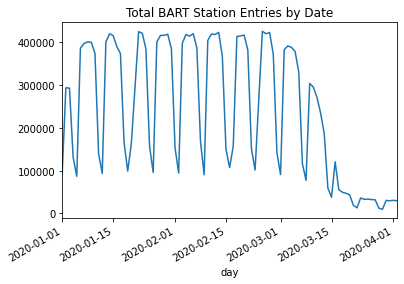

In [15]:
#fig,ax = plt.subplots()a
fig,ax=plt.subplots()
B.groupby('day').sum().sum(1).plot(kind='line',fig=fig)
fig.autofmt_xdate()
ax.set_title("Total BART Station Entries by Date")
fig.savefig('../dailyentries.png')

In [104]:
def station_locations(station_df,client):
    """
    Get station latlons from Google API
    """
    addresses = station_df['station']+" BART Station, " + station_df['location']+", CA"
    codes = dict(zip(addresses, station_df['CODE']))

    latlons = geo.geolocations(addresses, client)
    result = {}
    for address, loc in geo.ITEMS(latlons):
        try: loc[0][0] #~ make sure it's the normal [(lat,lon)] format
        except: loc = [loc] #~ Otherwise it's np.nan
        result[codes[address]] = loc
    return result

In [120]:
df = px.data.carshare()

In [121]:
df.head()

,centroid_lat,centroid_lon,car_hours,peak_hour
0,45.471549,-73.588684,1772.750000,2
1,45.543865,-73.562456,986.333333,23
2,45.487640,-73.642767,354.750000,20
3,45.522870,-73.595677,560.166667,23
4,45.453971,-73.738946,2836.666667,19


In [128]:
codes = stations['CODE'].to_list()
codes.remove("MLPT")
B = pd.DataFrame(B[codes].groupby(level='enter').sum().sum(1), columns=['rides'])

/home/elliott/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:951: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



ValueError: No axis named 1 for object type <class 'type'>

In [132]:
stations.head()

,CODE,rides2020,station,location,opened,ridership,parking
0,12TH,740363,12th Street Oakland City Center,Oakland,1972-9-11,14018,0
1,16TH,751539,16th Street Mission,San Francisco,1973-11-5,12478,0
2,19TH,760208,19th Street Oakland,Oakland,1972-9-11,13202,0
3,24TH,721254,24th Street Mission,San Francisco,1973-11-5,11888,0
4,ANTC,178224,Antioch,Antioch,2018-5-26,2898,1012
